In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import numpy as np
import yfinance as yf
from scipy.stats import norm

In [2]:
yf.pdr_override()
tickers = "^BVSP ^GSPC GC=F USDBRL=X"
carteira = yf.download(tickers, interval='1mo', start="2008-01-01")["Close"]
carteira.columns = ["OURO", "DOLAR", "IBOV", "S&P500"]
carteira = carteira.dropna()
carteira["OURO_BRL"]=carteira["OURO"]*carteira["DOLAR"]
carteira["S&P500_BRL"]=carteira["S&P500"]*carteira["DOLAR"]
retornos = carteira.pct_change()[1:]

[*********************100%***********************]  4 of 4 completed


In [3]:
def retorno_anual(r):
    """
    Anualiza o retorno de um conjunto de ativos
    """
    crescimento_composto = (1+r).prod()
    n_periodos = r.shape[0]
    return crescimento_composto**(12/n_periodos)-1

In [4]:
def portfolio_ret(pesos, retornos):
    """
    Calcula o retorno de uma carteira baseado nos seus retornos e pesos
    os pesos são uma matriz numpy ou matriz Nx1 e os retornos são uma matriz numpy ou matriz Nx1
    """
    return pesos.T @ retornos

In [5]:
def portfolio_vol(pesos, covmat):
    """
    Calcula a volatilidade de uma carteira a partir de uma matriz de covariância e pesos
    os pesos são uma matriz numpy ou N x 1 maxtrix e covmat é uma matriz N x N
    """
    return (pesos.T @ covmat @ pesos)**0.5

In [6]:
retornos_anualizado = retorno_anual(retornos["2008":"2022"])
cov_retornos = retornos["2008":"2022"].cov()

# Fronteira Eficiente - Executando o Otimizador

Para traçar a fronteira para carteiras com mais de 2 ativos, precisamos encontrar os pesos na carteira da fronteira eficiente.

Começamos criando o mesmo tipo de função que já criamos para o caso de 2 ativos:

In [7]:
def plot_front_ef(n_ptos, rets, cov):
    """
    Plota a fronteira eficiente de 2 ativos
    """
    if rets.shape[0] != 2 or rets.shape[0] != 2:
        raise ValueError("plot_front_ef pode plotar somente a fronteira de 2 ativos")
    pesos = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_ptos)]
    rets_ = [portfolio_ret(w, rets) for w in pesos]
    vols_ = [portfolio_vol(w, cov) for w in pesos]
    ef = pd.DataFrame({
        "Retornos": rets_, 
        "Volatilidade": vols_
    })
    return ef.plot.line(x="Volatilidade", y="Retornos", style=".-")


<AxesSubplot:xlabel='Volatilidade'>

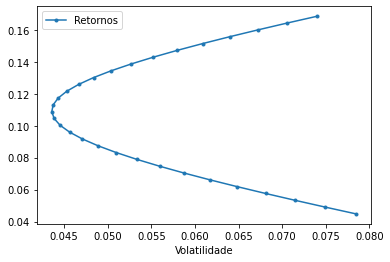

In [8]:
l = ["OURO_BRL", "IBOV"]
plot_front_ef(30, retornos_anualizado[l].values, cov_retornos.loc[l,l])

Para encontrar os pesos otimizados, precisamos de uma função que minimize a volatilidade para um determinado nível de retorno.

A Fronteira Eficiente para o portfolio que tem um retorno alvo de 0,125 é de aproximadamente 0,035, então vamos ver se nosso otimizador consegue localizá-lo.

In [9]:
from scipy.optimize import minimize

def minimiza_vol(retorno_alvo, rets, cov):
    """
    Retorna os pesos otimizados que atingem o retorno desejado
    dado um conjunto de retornos esperados e uma matriz de covariância
    """
    n = rets.shape[0]
    palpite_ini = np.repeat(1/n, n)
    limites = ((0.0, 1.0),) * n # uma N-tupla de 2-tuplas!
    #construir as restrições
    pesos_somar_ate_1 = {'type': 'eq',
                        'fun': lambda pesos: np.sum(pesos) - 1
    }
    retorno_alvo_ = {'type': 'eq',
                        'args': (rets,),
                        'fun': lambda pesos, rets: retorno_alvo - portfolio_ret(pesos, rets)
    }
    pesos = minimize(portfolio_vol, palpite_ini,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(pesos_somar_ate_1,retorno_alvo_),
                       bounds=limites)
    return pesos.x

In [10]:
pesos_125 = minimiza_vol(0.125, retornos_anualizado[l], cov_retornos.loc[l,l])
vol_125 = portfolio_vol(pesos_125, cov_retornos.loc[l,l])
vol_125

0.04638412937832268

Perfeito!

Agora que podemos encontrar os pesos para minimizar a volatilidade dado um retorno alvo, podemos traçar a fronteira eficiente dividindo o intervalo do retorno mais alto ao mais baixo possível em uma grade e encontrando a carteira que visa a volatilidade mínima dada um determinada taxa de retorno alvo.

In [11]:
def otimizador_pesos(n_ptos, rets, cov):
    """
    """
    rets_alvo = np.linspace(rets.min(), rets.max(), n_ptos)
    pesos = [minimiza_vol(retorno_alvo, rets, cov) for retorno_alvo in rets_alvo]
    return pesos

In [12]:
def plot_front_ef_v2(n_ptos, rets, cov):
    """
    Plota a fronteira eficiente de N ativos
    """

    pesos = otimizador_pesos(n_ptos, rets, cov) 
    rets_ = [portfolio_ret(w, rets) for w in pesos]
    vols_ = [portfolio_vol(w, cov) for w in pesos]
    ef = pd.DataFrame({
        "Retornos": rets_, 
        "Volatilidade": vols_
    })
    return ef.plot.line(x="Volatilidade", y="Retornos", style=".-")

<AxesSubplot:xlabel='Volatilidade'>

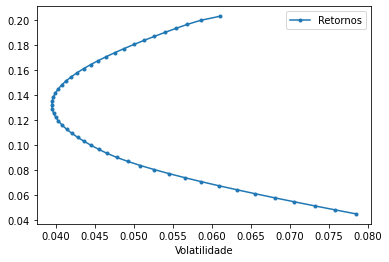

In [13]:
l = ["IBOV", "OURO_BRL", "S&P500_BRL"]
plot_front_ef_v2(50, retornos_anualizado[l].values, cov_retornos.loc[l,l])

In [14]:
peso_retorno_18 = minimiza_vol(0.15, retornos_anualizado[l], cov_retornos.loc[l,l])
print(l[0], ':', np.round(peso_retorno_18[0],2))
print(l[1], ':', np.round(peso_retorno_18[1],2))
print(l[2], ':', np.round(peso_retorno_18[2],2))

IBOV : 0.27
OURO_BRL : 0.28
S&P500_BRL : 0.45
